# PyCrCNN
This notebook is done to explain the main concepts and solutions used in PyCrCNN.

## Introduction
PyCrCNN is a client/server application which lets the server perform forward functions on some pre-determined Convolutional Neural Networks, when a request from a client is done.
The peculiarity of this application is that Homomorphic Encryption is used: the data coming from the client (in this case, an image) is encrypted and the server doesn't have the keys to decrypt it.

Computation on that is still allowed by the mathematical properties of this kind of encryption which is, in fact, homomorphic with respect to addiction and multiplication.

## External libraries used
For this application, these external libraries are used:

1. [Pyfhel](https://github.com/ibarrond/Pyfhel) - Homomorphic Encryption library
2. [numpy](https://numpy.org/) - Scientific computations
3. [jsonpickle](https://jsonpickle.github.io/index.html) - Serialization and deserialization of complex Python objects to and from JSON
4. [flask](https://flask.palletsprojects.com/en/) - Micro Web Framework

## Package organization

- convolutional: Code for convolutional layers
- crypto: Code for crypyographic operations, like encrypting matrix, encoding matrix, etc
- functional: Code for functional operations like Square Layers, AvgPool layers, etc
- linear: Code for linear layers
- net_builder: Code for building encoded model, starting from a PyTorch model
- network: Client and server code
- parameters_tester: Code to let user test the encryption parameters, given a model and such parameters. Statistics will be put in output.
- tests

## Functionalities

### Homomorphic Encryption
Every time a "HE" object is used, it refers to a Pyfhel object.
Usually, a Pyfhel object is built this way:

In [ ]:
HE = Pyfhel()
HE.contextGen(p=65537)
HE.keyGen()
HE.relinKeyGen(20, 10)

In the contextGen many others encryption parameters can be specified; refer to [Pyfhel documentation for more information](https://ibarrond.github.io/Pyfhel/html/index.html#Pyfhel.Pyfhel.contextGen).

### Encoded layers
Encoded layers are layers with the same characteristics of a normal PyTorch layer, but its weights have been encoded: this means that they are good to work on encrypted data.

In fact, in a normal forward on a normal CNN, computations between numbers are of the type:

    (Float, Float) -> Float
    
In an HE environment, computations between numbers are of the type:

    (EncryptedFrac, EncodedFrac) -> EncryptedFrac


In general, layers have been made with an eye on PyTorch definition: the reason is to be quite similar in the use to the correspondent PyTorch objects, without many differences.
For example, an encoded convolutional layer can be built with:

In [ ]:
ConvolutionalLayer(HE, 
                   weights=torchLayer.weight.detach().numpy(),
                   stride=torchLayer.stride, 
                   padding=torchLayer.padding, 
                   bias=torchLayer.bias)

The weights will be automatically encoded in Encoded Fractionals.

Furthermore, like in PyTorch, layers are callable objects: that means that, if we have an image (of the form of a numpy.array of EncryptedFrac), we can call the forward function off the layer just with

In [ ]:
results = encodedLayer(encrypted_image)

### Net builder
The code provided in the net_builder subpackage can retrieve a PyTorch model with some restrictions and build an encoded model with the same layers/weights: that is, an equivalent model able to work on encrypted data.

PyTorch model have to respect these constraints:
- It must be a [Sequential model](https://pytorch.org/docs/stable/nn.html#sequential)
- It must have extension .pt / .pth
- It must have been saved in PyTorch with the [save() function](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model).

If they are satisfied, the model can be built with:

In [ ]:
build_from_pytorch(HE, net, rencrypt_positions=[])

Where
- HE is a Pyfhel object
- net is the PyTorch object, loaded with the load() function
- rencrypt_positions can be used to put some rencryption layers in the resulting encoded model, i.e layers in which the input image is re-encrypted in order to restore the Noise Budget to the original level: in a real scenario, the server should send the partial results back to the client which will re-encrypt them and re-send them to the server to continue.

The function will return an ordered list of encoded layers.

### Parameter tester

The parameter tester loads a set of encryption parameters in JSON, a PyTorch model, and tests that model against its encoded corrispective on an image.
An example of input may be:

In [ ]:
{
  "encryption_parameters" : [
    {
      "m": 2048,
      "p": 13513511,
      "sec": 128,
      "base": 2,
      "rencrypt_positions": [ ]
    }
  ],
  "debug" : "y"
}

After the computation, a JSON results will be procuded: it will contain variouos information like the maximum error (that is the maximum difference between a value in the plain case and its corrispective encrypted value), the average error, the noise budget consumption etc.

### REST Client/Server
Built with flask, the server proides a REST endpoint to let client send requests for computations.
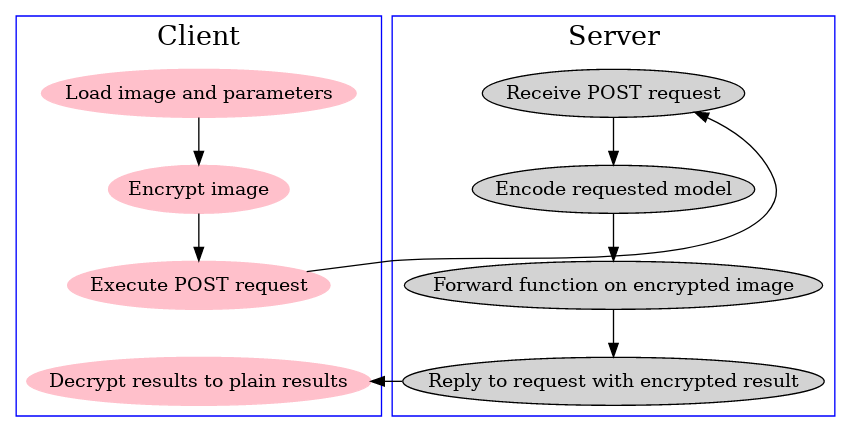

An example of client parameters is:

In [ ]:
{
  "address" : "http://127.0.0.1:5000/compute",
  "encryption_parameters" : [
    {
      "m": 2048,
      "p": 13513511,
      "sec": 128,
      "base": 2
    }
  ],
  "net" : "MNIST",
  "layers" : [0, 1, 2, 3]
}

In this example, the client is asking to forward the image on the net called "MNIST", only on layers from 0 to 3.
The client has encrypted the image with such parameters: the server will encode the model with them as well.